In [103]:
import logging, sys
logging.disable(sys.maxsize)
import pymongo
import pandas as pd
import statistics_utility as su
from web3 import Web3
import matplotlib
matplotlib.use('nbagg')
from evaluation.wallet_constant import BURNING_ADDRESSES
from evaluation.wallet_constant import LIQUIDITY_LOCKERS
from evaluation.evaluator import Evaluator
import evaluation.evaluation_config

from matplotlib import pyplot as plt
import numpy as np


plt.rcParams['figure.dpi'] = 100

db_client = pymongo.MongoClient("mongodb://localhost:27017/")
scam_db = db_client["eth-scam-checker"]

#statistics_db = db_client['statistics']
#statistics_rescan_db = db_client['statistics-rescan']
# statistics_db = db_client['statistics-big-legit-dataset']
# statistics_rescan_db = db_client['statistics-big-legit-dataset-rescan']
# statistics_db = db_client['statistics-big-dataset']
# statistics_rescan_db = db_client['statistics-big-dataset-rescan']


# big_dataset_db = db_client['statistics-big-dataset']
# big_dataset_rescan_db = db_client['statistics-big-dataset-rescan']

big_dataset_50_50_db = db_client['big-dataset-50-50']
big_dataset_50_50_rescan_db = db_client['big-dataset-50-50-rescan']

statistics_db = db_client['big-dataset-50-50']
statistics_rescan_db = db_client['big-dataset-50-50-rescan']

testset_db = db_client['testset-db']
testset_rescan_db = db_client['testset-rescan-db']


# statistics_db = db_client['testset-db']
# statistics_rescan_db = db_client['testset-rescan-db']

logger = logging.getLogger(__name__)


# dataset_file = "./data/big_dataset_annotated_with_legit.csv"
# data = pd.read_csv(dataset_file)

#dataset_file = "./data/first_dataset.CSV"
#data = pd.read_csv(dataset_file)

# dataset_file = "./data/big_dataset_annotated.csv"
# data = pd.read_csv(dataset_file)

# dataset_file = "./data/big_dataset_annotated.csv"
# data = pd.read_csv(dataset_file)

# dataset_file = "./data/random_tokens_annotated.csv"
# data = pd.read_csv(dataset_file)

dataset_file = "./data/big_dataset_50_50.csv"
# dataset_file = "./data/big_dataset_current.csv"
data = pd.read_csv(dataset_file)


dataset_testset_file = "./data/test_dataset.CSV"
data_testset = pd.read_csv(dataset_testset_file)

# dataset_file = "./data/test_dataset.CSV"
# data = pd.read_csv(dataset_file)

    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Liquidity Amount Setup

In [230]:
# eth amount plot
liquidity_values = []
annotations = []
numbers = []
no_eth_pair_scam = 0
no_eth_pair_benign = 0

low_liquidity_scam_count = 0
low_liquidity_benign_count = 0

liquidity_scam = []
liquidity_benign = []

r = np.arange(1)
width = 0.25

# for index, entry in data_testset.iterrows():
for index, entry in data.iterrows():
#     token = testset_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
 
    eth_liquidity = evaluator.get_eth_liquidity()

    if eth_liquidity is None:
        if entry['Scam'] == 1:
            no_eth_pair_scam += 1
        else:
            no_eth_pair_benign += 1
    elif eth_liquidity > 400:
        liquidity_values.append(405)
        numbers.append(index)
        annotations.append(entry['Scam'])
    else:
        liquidity_values.append(eth_liquidity)
        numbers.append(index)
        annotations.append(entry['Scam'])
    
    if eth_liquidity is not None and eth_liquidity > 40:
        if entry['Scam'] == 1:
            low_liquidity_scam_count += 1
        else:
            low_liquidity_benign_count += 1
            
    if eth_liquidity is not None:
        if entry['Scam'] == 1:
            liquidity_scam.append(eth_liquidity)
        else:
            liquidity_benign.append(eth_liquidity)
        

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_liquidity_values = pd.DataFrame({"x": np.arange(len(liquidity_values)), "y":liquidity_values, "scam":annotations})

plot_colors = []

for i in annotations:
    plot_colors.append(colors[i])
        
print(df_liquidity_values)

       x             y  scam
0      0  8.445590e-01     0
1      1  2.000000e+00     1
2      2  3.510000e+00     1
3      3  1.337819e+00     1
4      4  3.613007e+00     1
..   ...           ...   ...
337  337  4.050000e+02     0
338  338  1.023361e+00     0
339  339  8.333734e-01     0
340  340  3.240178e-01     1
341  341  6.000000e-18     1

[342 rows x 3 columns]


### Liquidity Amount Plot
plots different views based on the previous setup cell

<IPython.core.display.Javascript object>


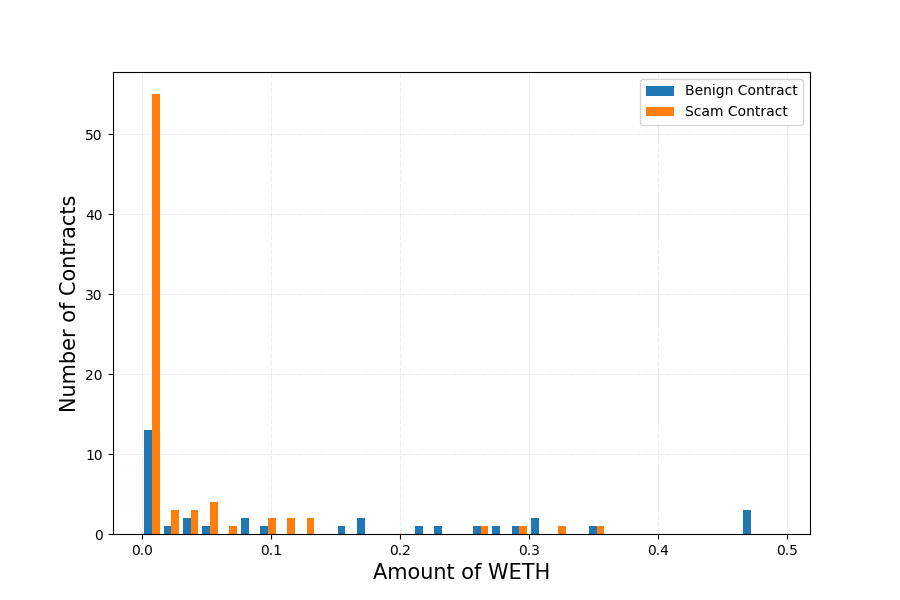

2
0.1764705882352941


In [227]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

# axs1.hist(liquidity_values, bins=60)
bins = np.arange(0,0.5,0.015)
ax.hist((liquidity_benign, liquidity_scam), bins=bins, label=('Benign Contract','Scam Contract'))

# axs3.bar(r, [no_eth_pair_scam], color='r', width=width, label='scams')
# axs3.bar(r+width, [no_eth_pair_benign], color='g', width=width, label='benign')
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# plt.xlim([0,100])
plt.ylabel('Number of Contracts', fontsize = 15)
plt.xlabel('Amount of WETH', fontsize = 15)
plt.legend()

print(no_eth_pair_scam + no_eth_pair_benign)
plt.show()

print(1.0 / (low_liquidity_scam_count + low_liquidity_benign_count) * low_liquidity_scam_count)

<IPython.core.display.Javascript object>


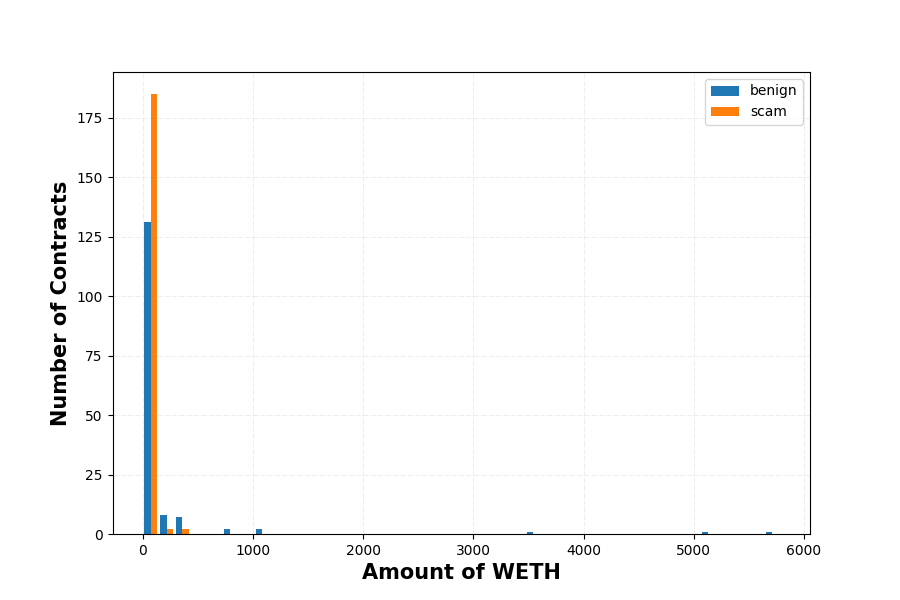

In [224]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

# axs1.hist(liquidity_values, bins=60)
# bins = np.arange(0,105,1)
ax.hist((liquidity_benign, liquidity_scam), bins=40, label=('benign','scam'))

# axs3.bar(r, [no_eth_pair_scam], color='r', width=width, label='scams')
# axs3.bar(r+width, [no_eth_pair_benign], color='g', width=width, label='benign')
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
plt.ylabel('Number of Contracts', fontweight ='bold', fontsize = 15)
plt.xlabel('Amount of WETH', fontweight ='bold', fontsize = 15)
plt.legend()

plt.show()


<IPython.core.display.Javascript object>


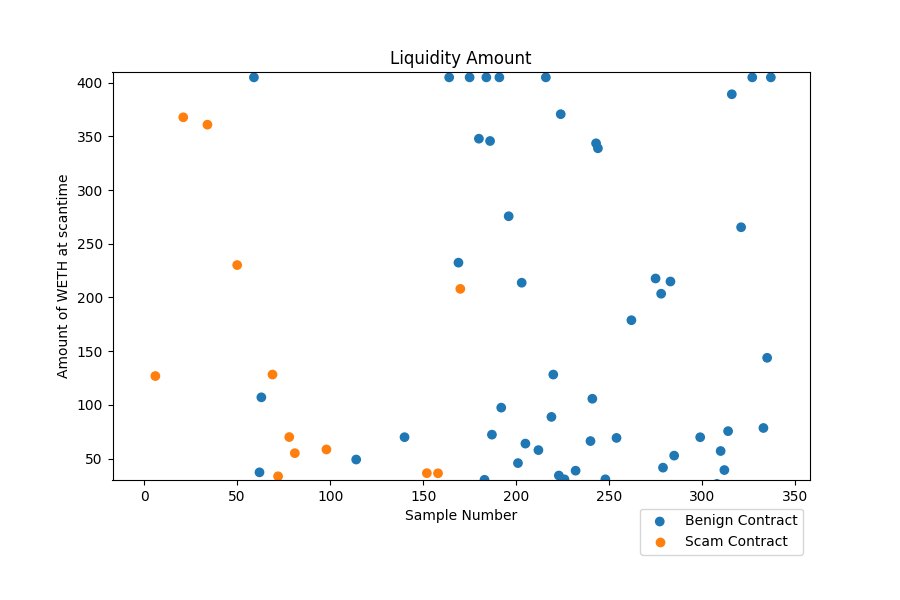

In [232]:
%matplotlib notebook

fig, ax = plt.subplots(figsize =(9, 6))

# ax.semilogy()
ax.scatter(df_liquidity_values['x'], df_liquidity_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(None, None , c=colors[1], label="Scam Contract")
ax.set_ylabel("Amount of WETH at scantime")
ax.set_xlabel("Sample Number")
ax.set_title("Liquidity Amount")
plt.legend(loc=4, bbox_to_anchor=(1,-0.2))
plt.subplots_adjust(bottom=0.2)

plt.ylim([30,410])
plt.show()

<IPython.core.display.Javascript object>


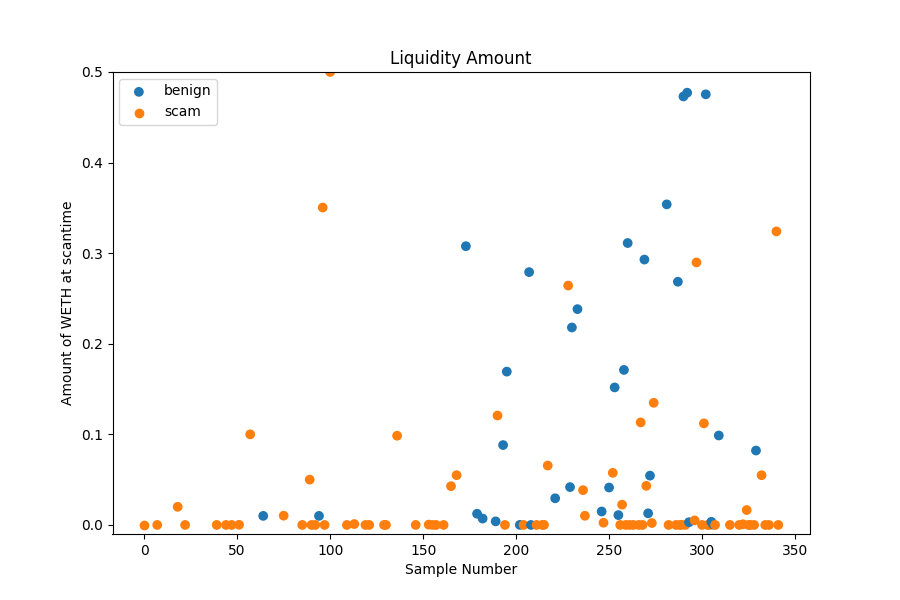

In [126]:
%matplotlib notebook

fig, ax = plt.subplots(figsize =(9, 6))

# ax.semilogy()
ax.scatter(df_liquidity_values['x'], df_liquidity_values['y'] , c=plot_colors, label="benign") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="scam")

# ax.scatter(np.arange(len(liquidity_values)), liquidity_values , c=annotations) #label=annotations)
ax.set_ylabel("Amount of WETH at scantime")
ax.set_xlabel("Sample Number")
ax.set_title("Liquidity Amount")
ax.legend()
plt.ylim([-0.01,0.5])
plt.show()

<IPython.core.display.Javascript object>


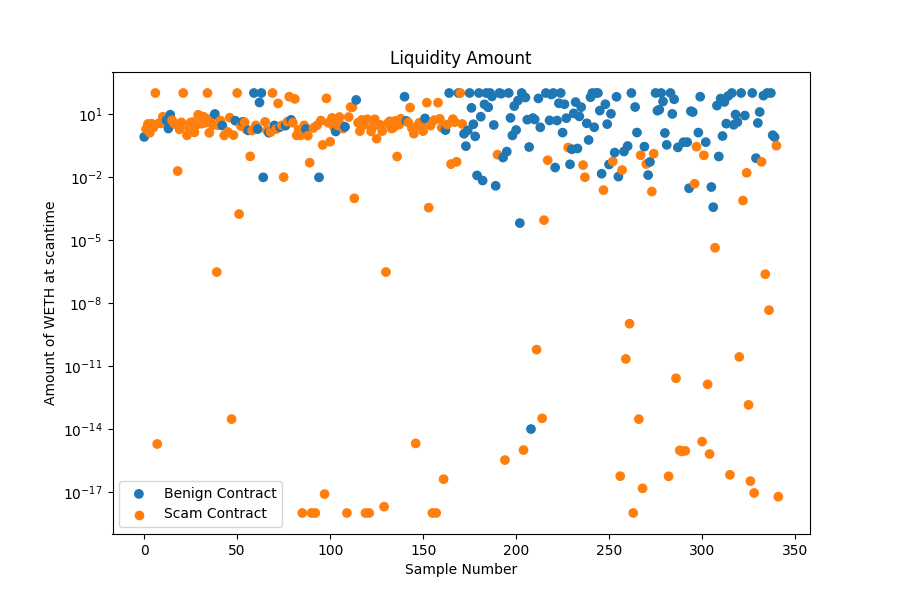

In [223]:
%matplotlib notebook

fig, ax = plt.subplots(figsize =(9, 6))
ax.semilogy()

# for i, dff in df_liquidity_values.groupby("scam"):
#     ax.scatter(dff['x'], dff['y'], c=colors[i])
ax.scatter(df_liquidity_values['x'], df_liquidity_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="Scam Contract")
ax.set_ylabel("Amount of WETH at scantime")
ax.set_xlabel("Sample Number")
ax.set_title("Liquidity Amount")
ax.legend()
# plt.ylim([-80,1250])
plt.show()

<IPython.core.display.Javascript object>


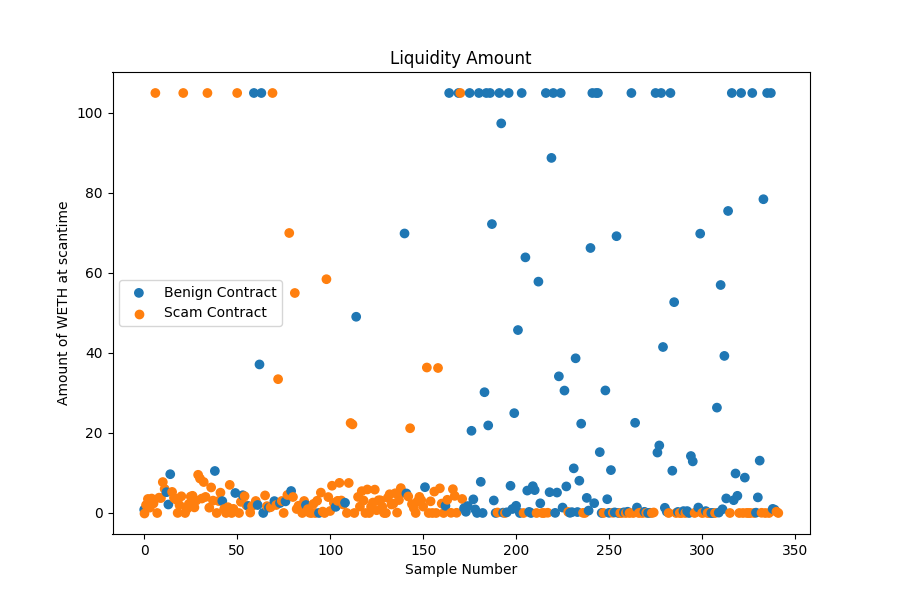

In [222]:
%matplotlib notebook

fig, ax = plt.subplots(figsize =(9, 6))

# ax.semilogy()
ax.scatter(df_liquidity_values['x'], df_liquidity_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="Scam Contract")
ax.set_ylabel("Amount of WETH at scantime")
ax.set_xlabel("Sample Number")
ax.set_title("Liquidity Amount")
ax.legend()
plt.show()

### Liquidity holder shares setup
Collects data and formats it for further processing

In [149]:
liquidity_holder_values = []
annotations = []
numbers = []

liquidity_holders_benign = []
liquidity_holders_scam = []


liquidity_scores_scam = []
liquidity_scores_benign = []

most_burnt_scam_counter = 0
no_most_burnt_scam_counter = 0
most_burnt_benign_counter = 0
no_most_burnt_benign_counter = 0

# for index, entry in data_testset.iterrows():
for index, entry in data.iterrows():
#     token = testset_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    annotations.append(entry['Scam'])
    numbers.append(index)
    
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    score = evaluator._evaluate_liquidity_holders()
    
    share = evaluator.get_highest_liquidity_holder_share()

#     if mostly_burnt:
#         if entry['Scam'] == 1:
#             most_burnt_scam_counter += 1
#         else:
#             most_burnt_benign_counter += 1
#     else:
#         if entry['Scam'] == 1:
#             no_most_burnt_scam_counter += 1
#         else:
#             no_most_burnt_benign_counter += 1
    if entry['Scam'] == 1:
        liquidity_scores_scam.append(score)
    else:
        liquidity_scores_benign.append(score)

    if share is None:
        liquidity_holder_values.append(-1)
        if entry['Scam'] == 1:
            liquidity_holders_scam.append(-1)
        else:
            liquidity_holders_benign.append(-1)
    else:
        liquidity_holder_values.append(share)
        if entry['Scam'] == 1:
            liquidity_holders_scam.append(share)
        else:
            liquidity_holders_benign.append(share)

        
# print(liquidity_holder_values)
# print(len(liquidity_holder_values))

# print(annotations)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_liquidity_holder_values = pd.DataFrame({"x": np.arange(len(liquidity_holder_values)), "y":liquidity_holder_values, "scam":annotations})

plot_colors = []

for i in annotations:
    plot_colors.append(colors[i])


### Liquidity holder share plots
Needs the previous cell to be run to ensure all data is up to date

<IPython.core.display.Javascript object>


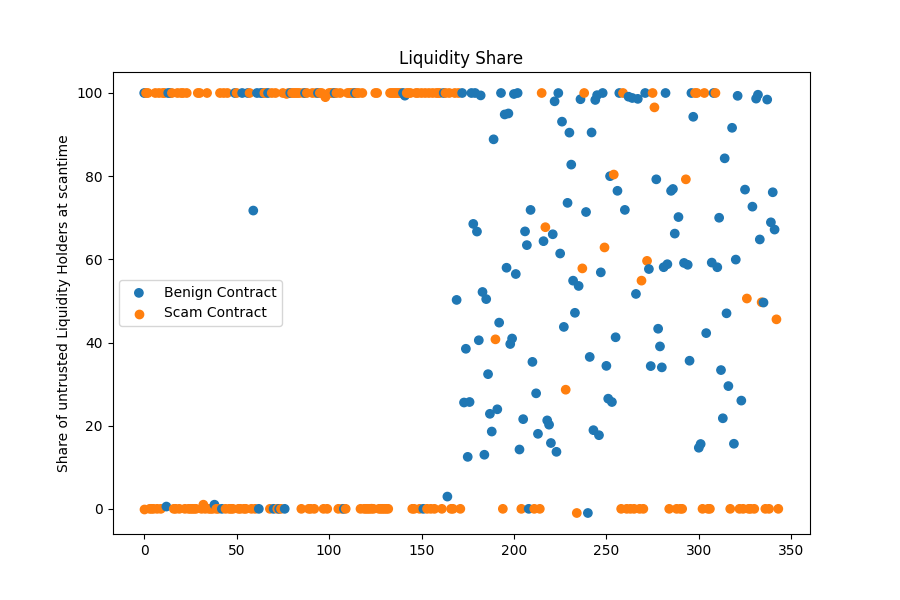

In [197]:


%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

ax.scatter(df_liquidity_holder_values['x'], df_liquidity_holder_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="Scam Contract")
plt.ylabel("Share of untrusted Liquidity Holders at scantime")
plt.title("Liquidity Share")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


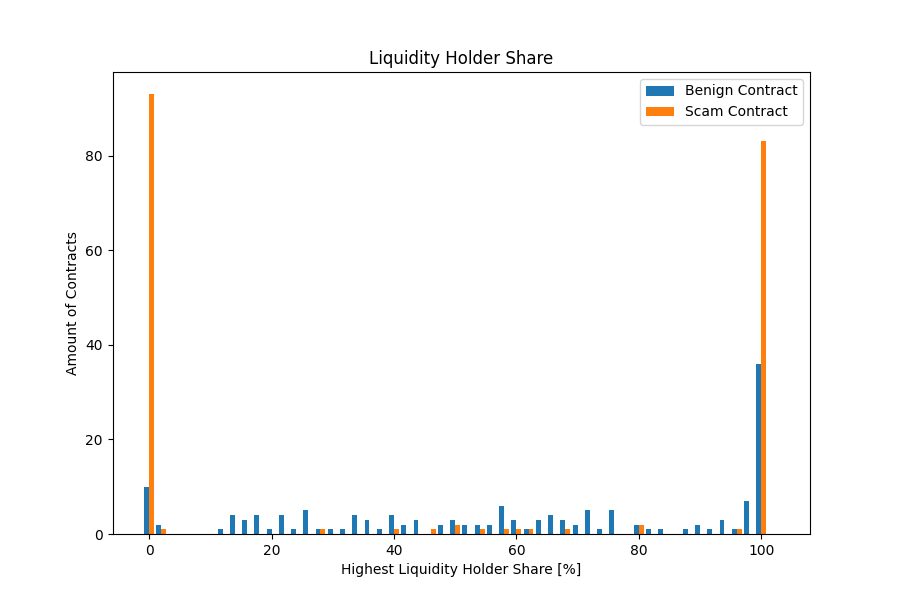

Text(0.5, 1.0, 'Liquidity Holder Share')

In [196]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

bins = np.arange(-1,105,2)
plt.hist((liquidity_holders_benign, liquidity_holders_scam), bins=bins, label=("Benign Contract","Scam Contract"))
plt.ylabel("Amount of Contracts")
plt.xlabel("Highest Liquidity Holder Share [%]")
plt.legend()
plt.title("Liquidity Holder Share")

<IPython.core.display.Javascript object>


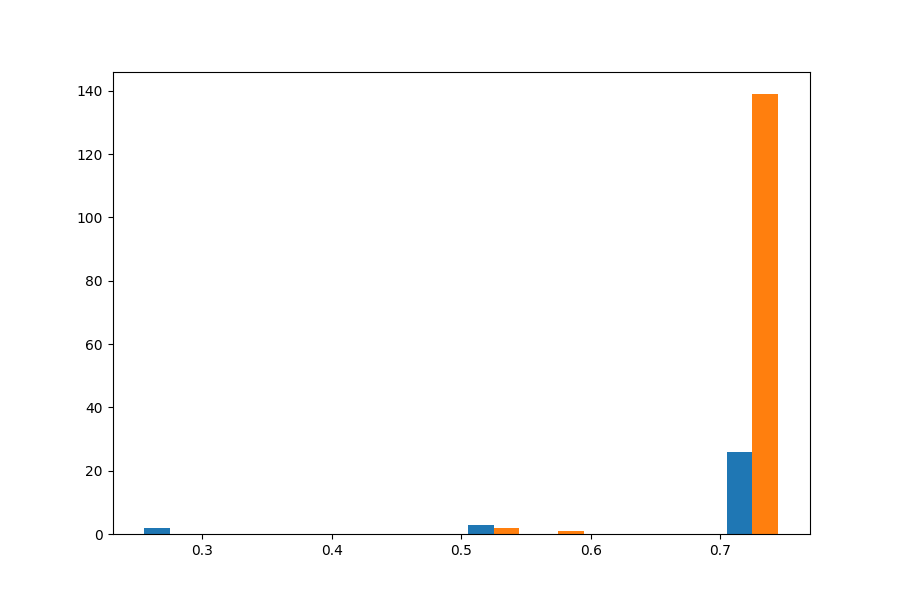

(array([[  2.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,  26.],
        [  0.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   0., 139.]]),
 array([0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75]),
 <a list of 2 BarContainer objects>)

In [24]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

# bins = np.arange(-1,105,2)
plt.hist((liquidity_scores_benign,liquidity_scores_scam))

# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(x[i],y[i],y[i])

# %matplotlib notebook
# fig, ax = plt.subplots(figsize =(9, 6))


# barWidth = 0.25

# br1 = np.arange(2)
# br2 = [x + barWidth for x in br1]

# plt.bar(br1, [no_most_burnt_benign_counter, most_burnt_benign_counter], width = barWidth,
#         edgecolor ='grey', label ='Benign Contracts')



# plt.bar(br2, [no_most_burnt_scam_counter, most_burnt_scam_counter], width = barWidth,
#         edgecolor ='grey', label ='Scam Contracts')

# addlabels(br1, [no_most_burnt_benign_counter, most_burnt_benign_counter])

# addlabels(br2, [no_most_burnt_scam_counter, most_burnt_scam_counter])


# # plt.xlabel('', fontweight ='bold', fontsize = 15)
# plt.ylabel('Number of Contracts', fontweight ='bold', fontsize = 15)
# plt.xticks([r + barWidth for r in range(2)],
#         ['No mostly burned liquidity Contracts', 'Mostly burned liquidity Contracts'])
 
# ax.grid(visible = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.2)


# plt.legend()
# plt.show()

### Token holder share setup

In [140]:
token_holder_values = []
annotations = []
numbers = []

holder_share_scam = []
holder_share_benign = []

for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    share = evaluator.get_highest_token_holder_share()
    annotations.append(entry['Scam'])
#     print(token['address'])
#     print(entry['Scam'])
#     print(share)
    numbers.append(index)
    
    if share is None:
        token_holder_values.append(-1)
        if entry['Scam'] == 1:
            holder_share_scam.append(-1)
        else:
            holder_share_benign.append(-1)
        continue
    
    elif share > 100:
        token_holder_values.append(105)
        if entry['Scam'] == 1:
            holder_share_scam.append(105)
        else:
            holder_share_benign.append(105)
        continue
    elif share < 0:
        token_holder_values.append(0)
        if entry['Scam'] == 1:
            holder_share_scam.append(0)
        else:
            holder_share_benign.append(0)
        continue
    else: 
        token_holder_values.append(share)
        if entry['Scam'] == 1:
            holder_share_scam.append(share)
        else:
            holder_share_benign.append(share)
        continue

        
# print(token_holder_values)
# print(annotations)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_holder_share_values = pd.DataFrame({"x": np.arange(len(token_holder_values)), "y":token_holder_values, "scam":annotations})

plot_colors = []

for i in annotations:
    plot_colors.append(colors[i])



### Toklen holder share plots
plots token holder share statistics based on setup of above cell

<IPython.core.display.Javascript object>


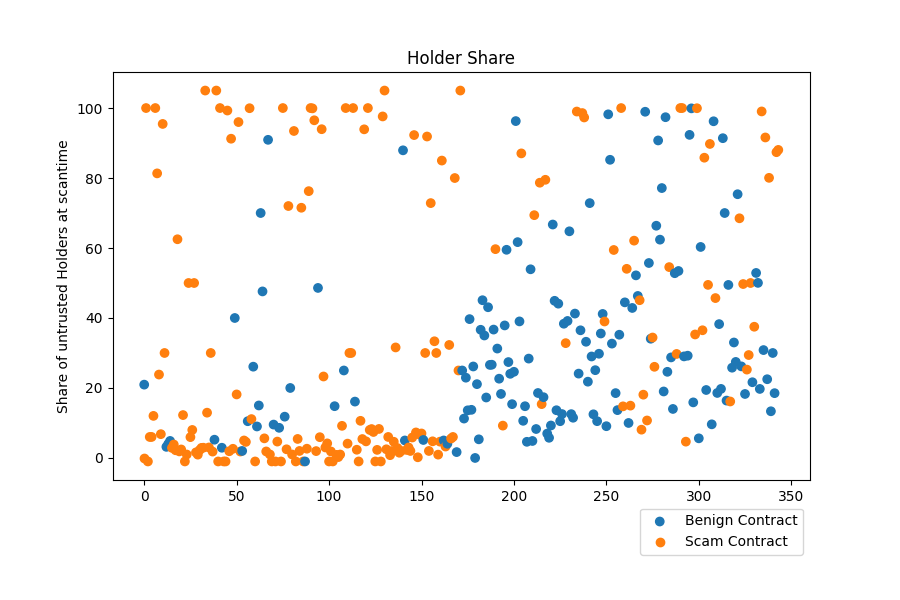

In [218]:

%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

ax.scatter(df_holder_share_values['x'], df_holder_share_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="Scam Contract")
plt.legend(loc=4, bbox_to_anchor=(1,-0.2))
plt.ylabel("Share of untrusted Holders at scantime")
plt.title("Holder Share")
plt.subplots_adjust(bottom=0.2)

plt.show()


<IPython.core.display.Javascript object>


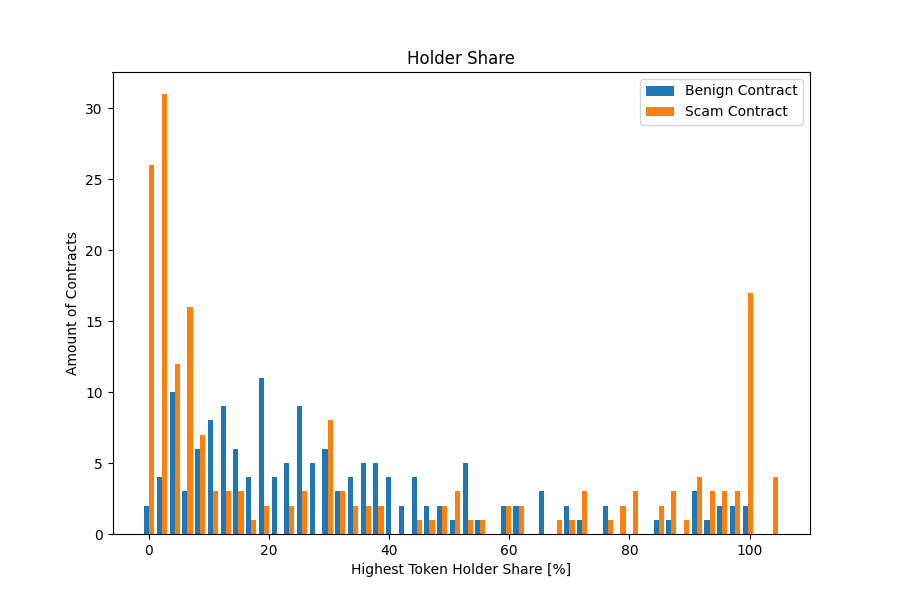

Text(0.5, 1.0, 'Holder Share')

In [219]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

plt.hist((holder_share_benign, holder_share_scam), bins=50, label=('Benign Contract','Scam Contract'))
plt.ylabel("Amount of Contracts")
plt.xlabel("Highest Token Holder Share [%]")
plt.legend()
plt.title("Holder Share")

(57, 133, 8, 146)
0.8769230769230769


<IPython.core.display.Javascript object>


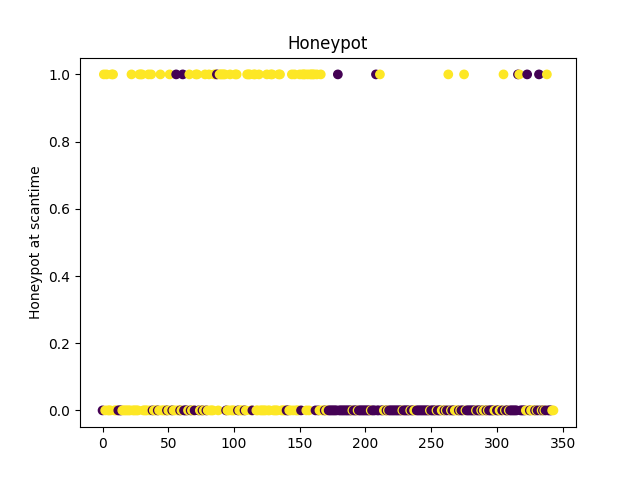

Text(0.5, 1.0, 'Honeypot')

In [194]:
honeypot_values = []
annotations = []
numbers = []

honeypot_scam_counter = 0
no_honeypot_scam_counter = 0
honeypot_benign_counter = 0
no_honeypot_benign_counter = 0

for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    honeypot = token['honeypot']['IsHoneypot']

    if honeypot is True:
        honeypot_values.append(1)
    else:
        honeypot_values.append(0)
        
    annotations.append(entry['Scam'])
    numbers.append(index)
    if entry['Scam'] == 1:
        if honeypot:
            honeypot_scam_counter += 1
        else:
            no_honeypot_scam_counter += 1
    else:
        if honeypot:
            honeypot_benign_counter += 1
        else:
            no_honeypot_benign_counter += 1    
            

print((honeypot_scam_counter, no_honeypot_scam_counter, honeypot_benign_counter, no_honeypot_benign_counter))
print( 1.0/ (honeypot_benign_counter + honeypot_scam_counter) * honeypot_scam_counter )

# print(honeypot_values)
# print(annotations)
df = pd.DataFrame(honeypot_values)
%matplotlib notebook

plt.scatter(numbers, honeypot_values , c=annotations) #label=annotations)
plt.ylabel("Honeypot at scantime")
plt.title("Honeypot")

# anderes format
# vertikal balken kummuliert


<IPython.core.display.Javascript object>


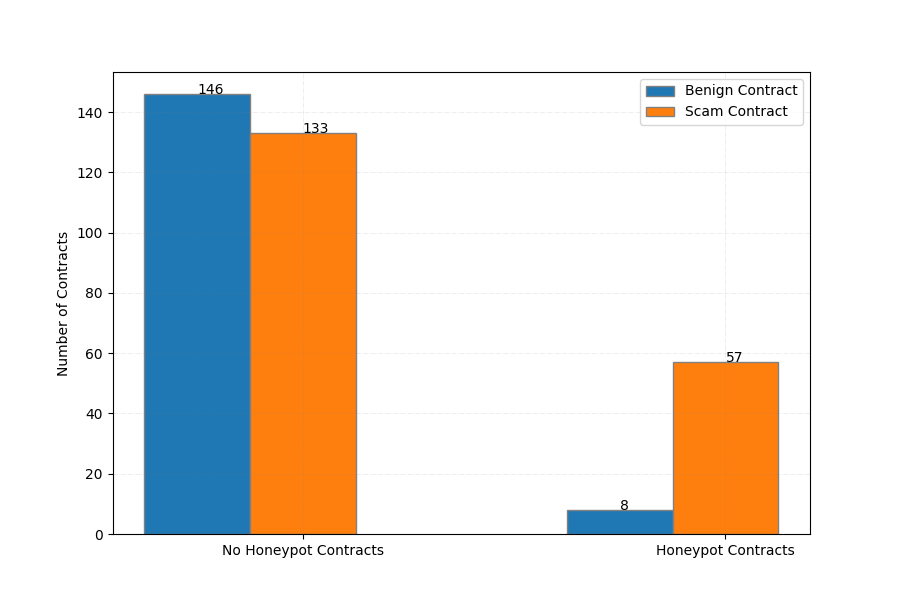

In [195]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],y[i])

%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

barWidth = 0.25

br1 = np.arange(2)
br2 = [x + barWidth for x in br1]

plt.bar(br1, [no_honeypot_benign_counter, honeypot_benign_counter], width = barWidth,
        edgecolor ='grey', label ='Benign Contract')



plt.bar(br2, [no_honeypot_scam_counter, honeypot_scam_counter], width = barWidth,
        edgecolor ='grey', label ='Scam Contract')

addlabels(br1, [no_honeypot_benign_counter, honeypot_benign_counter])

addlabels(br2, [no_honeypot_scam_counter, honeypot_scam_counter])


# plt.xlabel('', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Contracts')
plt.xticks([r + barWidth for r in range(2)],
        ['No Honeypot Contracts', 'Honeypot Contracts'])
 
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)


plt.legend()
plt.show()

<IPython.core.display.Javascript object>


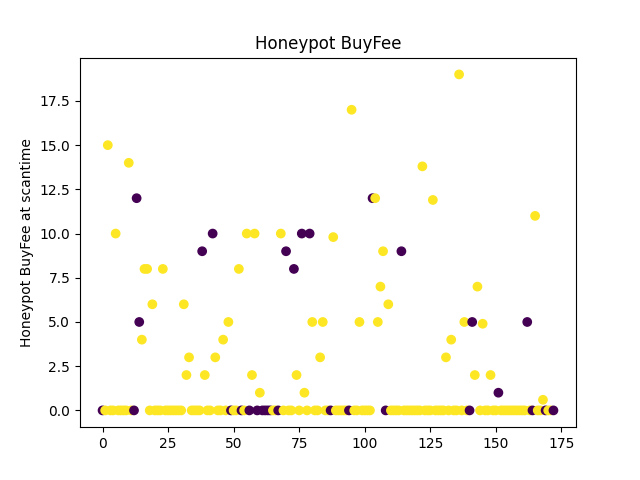

Text(0.5, 1.0, 'Honeypot BuyFee')

In [30]:
honeypot_buy_fees_values = []
annotations = []
numbers = []

for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    honeypot_buy_fee = float(token['honeypot']['BuyTax'])
    
    honeypot_buy_fees_values.append(honeypot_buy_fee)
        
    annotations.append(entry['Scam'])
    numbers.append(index)
        
# print(honeypot_buy_fees_values)
# print(annotations)
df = pd.DataFrame(honeypot_buy_fees_values)
%matplotlib notebook
plt.scatter(numbers, honeypot_buy_fees_values , c=annotations) #label=annotations)
plt.ylabel("Honeypot BuyFee at scantime")
plt.title("Honeypot BuyFee")

In [ ]:
honeypot_sell_fees_values = []
annotations = []
numbers = []

for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    honeypot_sell_fee = float(token['honeypot']['SellTax'])
    
    honeypot_sell_fees_values.append(honeypot_sell_fee)
        
    annotations.append(entry['Scam'])
    numbers.append(index)
        
# print(honeypot_sell_fees_values)
# print(annotations)
df = pd.DataFrame(honeypot_sell_fees_values)
%matplotlib notebook
plt.scatter(numbers, honeypot_sell_fees_values , c=annotations) #label=annotations)
plt.ylabel("Honeypot SellFee at scantime")
plt.title("Honeypot SellFee")

<IPython.core.display.Javascript object>


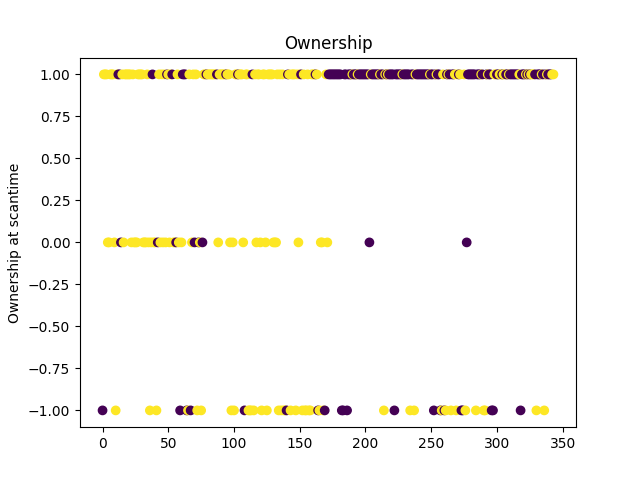

Text(0.5, 1.0, 'Ownership')

In [191]:
ownership_values = []
annotations = []
numbers = []

ownership_scam = []
ownership_benign = []

ownership_scam_counter = 0
ownership_benign_counter = 0
no_ownership_scam_counter = 0
no_ownership_benign_counter = 0
renounced_ownership_scam_counter = 0
renounced_ownership_benign_counter = 0

for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    ownership_renounced = evaluator.get_renounced_ownership()

    if ownership_renounced is None:
        ownership_values.append(-1)
        if entry['Scam'] == 1:
            ownership_scam.append(-1)
            no_ownership_scam_counter += 1
        else:
            ownership_benign.append(-1)
            no_ownership_benign_counter += 1
    elif ownership_renounced == 0.0:
        ownership_values.append(0)
        if entry['Scam'] == 1:
            ownership_scam.append(0)
            renounced_ownership_scam_counter += 1
        else:
            ownership_benign.append(0)
            renounced_ownership_benign_counter += 1
    else:
        ownership_values.append(1)
        if entry['Scam'] == 1:
            ownership_scam.append(1)
            ownership_scam_counter += 1
        else:
            ownership_benign.append(1)
            ownership_benign_counter +=1
            
    annotations.append(entry['Scam'])
    numbers.append(index)
        
# print(ownership_values)
# print(annotations)
df = pd.DataFrame(ownership_values)
%matplotlib notebook
plt.scatter(numbers, ownership_values , c=annotations) #label=annotations)
plt.ylabel("Ownership at scantime")
plt.title("Ownership")

# vertikal balken diagramm

<IPython.core.display.Javascript object>


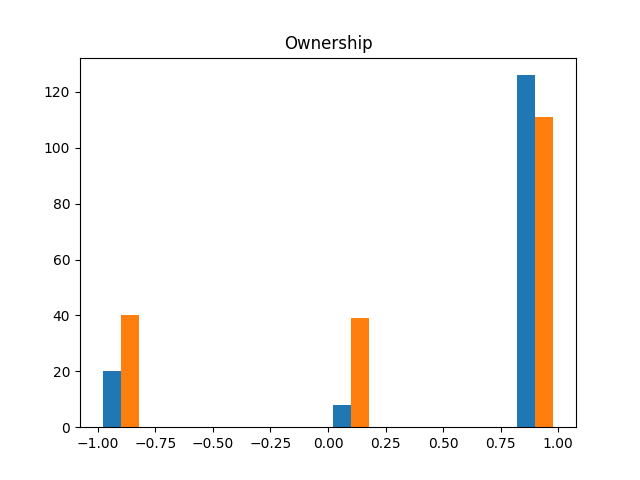

In [192]:
%matplotlib notebook

plt.hist((ownership_benign,ownership_scam))
plt.title("Ownership")
plt.show()

<IPython.core.display.Javascript object>


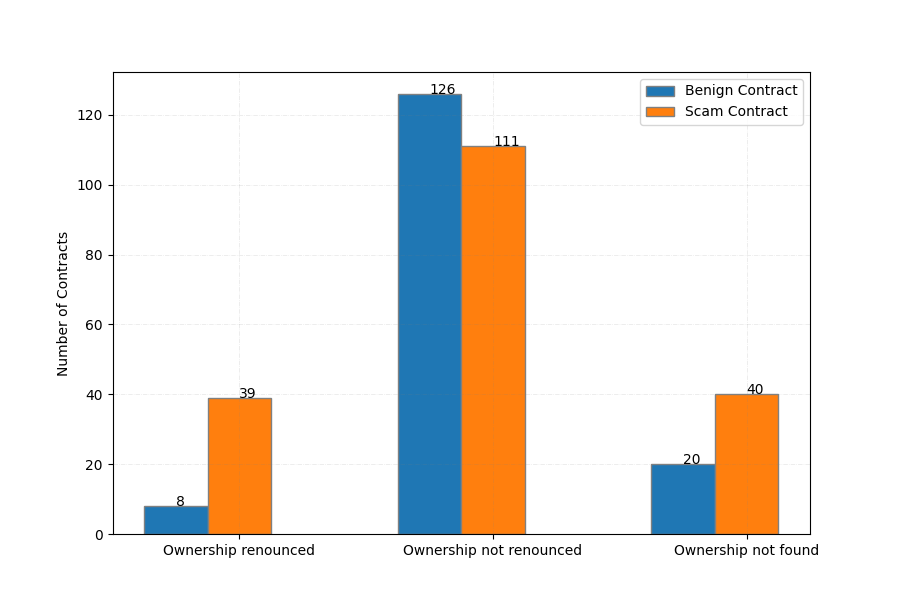

In [193]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],y[i])


        
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

barWidth = 0.25

br1 = np.arange(3)
br2 = [x + barWidth for x in br1]


plt.bar(br1, [renounced_ownership_benign_counter, ownership_benign_counter, no_ownership_benign_counter], width = barWidth,
        edgecolor ='grey', label ='Benign Contract')



plt.bar(br2, [renounced_ownership_scam_counter, ownership_scam_counter, no_ownership_scam_counter], width = barWidth,
        edgecolor ='grey', label ='Scam Contract')

addlabels(br1, [renounced_ownership_benign_counter, ownership_benign_counter, no_ownership_benign_counter])

addlabels(br2, [renounced_ownership_scam_counter, ownership_scam_counter, no_ownership_scam_counter])


# plt.xlabel('', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Contracts')
plt.xticks([r + barWidth for r in range(3)],
        ['Ownership renounced', 'Ownership not renounced', 'Ownership not found'])
 
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)


plt.legend()
plt.show()

(163, 27, 148, 6)
0.8181818181818182


<IPython.core.display.Javascript object>


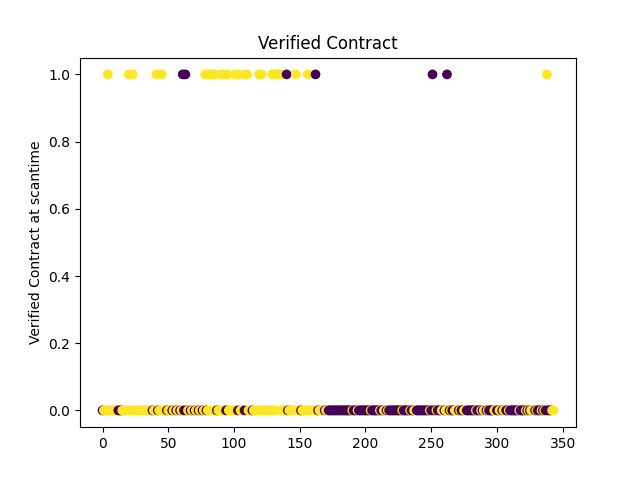

In [236]:
verified_contract_values = []
annotations = []
numbers = []

verified_scam_counter = 0
verified_benign_counter = 0
unverified_scam_counter = 0
unverified_benign_counter = 0

for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    verified_contract = evaluator.get_verified_contract()

    if verified_contract:
        verified_contract_values.append(0)
    else:
        verified_contract_values.append(1)
        
    annotations.append(entry['Scam'])
    numbers.append(index)
    
    if entry['Scam'] == 1:
        if verified_contract:
            verified_scam_counter += 1
        else:
            unverified_scam_counter += 1
    else:
        if verified_contract:
            verified_benign_counter += 1
        else:
            unverified_benign_counter += 1        
        
print((verified_scam_counter, unverified_scam_counter, verified_benign_counter, unverified_benign_counter))
print( 1.0/ (unverified_benign_counter + unverified_scam_counter) * unverified_scam_counter )
# print(verified_contract_values)
# print(annotations)

%matplotlib notebook
plt.scatter(numbers, verified_contract_values , c=annotations) #label=annotations)
plt.ylabel("Verified Contract at scantime")
plt.title("Verified Contract")
plt.show()


<IPython.core.display.Javascript object>


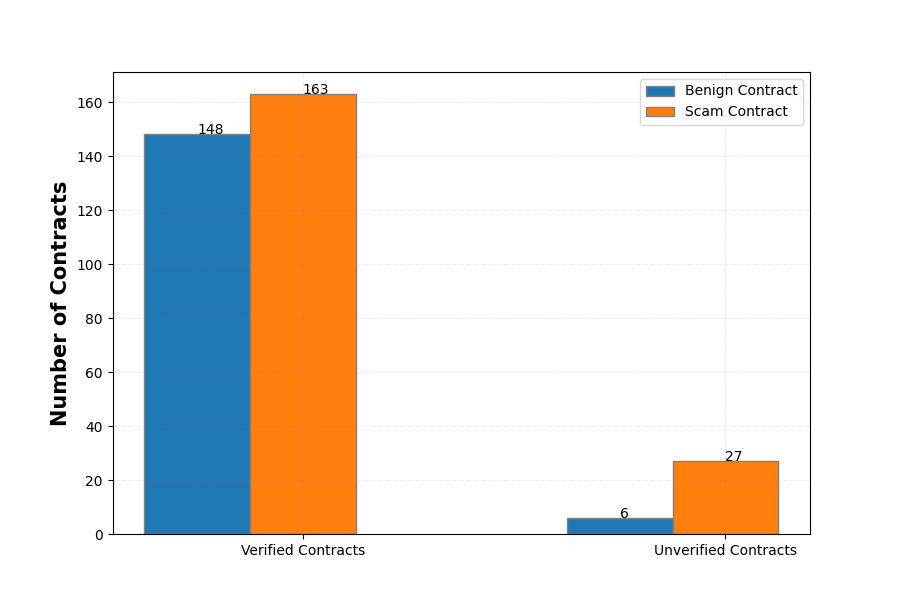

In [237]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],y[i])

%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

barWidth = 0.25

br1 = np.arange(2)
br2 = [x + barWidth for x in br1]

plt.bar(br1, [verified_benign_counter, unverified_benign_counter], width = barWidth,
        edgecolor ='grey', label ='Benign Contract')



plt.bar(br2, [verified_scam_counter, unverified_scam_counter], width = barWidth,
        edgecolor ='grey', label ='Scam Contract')

addlabels(br1, [verified_benign_counter, unverified_benign_counter])

addlabels(br2, [verified_scam_counter, unverified_scam_counter])


# plt.xlabel('', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Contracts', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)],
        ['Verified Contracts', 'Unverified Contracts'])
 
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)


plt.legend()
plt.show()

<IPython.core.display.Javascript object>


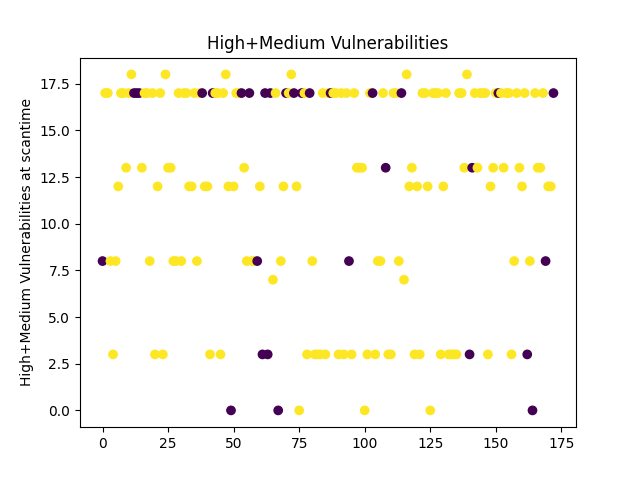

Text(0.5, 1.0, 'High+Medium Vulnerabilities')

In [36]:
slither_high_values = []
annotations = []
numbers = []

scam_vulns = []
benign_vulns = []

benign_vuln_high_counter = 0
scam_vuln_high_counter = 0

benign_vuln_medium_counter = 0
scam_vuln_medium_counter = 0

benign_vuln_invalid_counter = 0
scam_vuln_invalid_counter = 0


for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
#     slither_results = token['verified_contract']['slither_results']
    numbers.append(index)
    annotations.append(entry['Scam'])

    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    impact, confidence = evaluator.get_highest_vulnerability()
    
    if impact is None:
        slither_high_values.append(-1)
        continue
    
    slither_high_values.append((impact*5+confidence))
    
    if entry['Scam'] == 1:
        if verified_contract:
            verified_scam_counter += 1
        else:
            unverified_scam_counter += 1
    else:
        if verified_contract:
            verified_benign_counter += 1
        else:
            unverified_benign_counter += 1        

    
    if entry['Scam'] == 1:
        scam_vulns.append((impact*5+confidence))
    else:
        benign_vulns.append((impact*5+confidence))
    
#     if slither_results['error'] == 1:
#         slither_high_values.append(-1)
#         continue
    
#     high_found = None
#     reentrancy_found = None

#     for vuln in slither_results['vulnerabilities']:     
#         if vuln['impact'] in ["High"] and vuln['confidence'] in ["High"]:
#             high_found = True
#         if vuln['check'] == "reentrancy-eth":
#             reentrancy_found = True


#     if high_found is True:
#         slither_high_values.append(1)
#     elif reentrancy_found:
#         slither_high_values.append(0.5)

#     else:
#         slither_high_values.append(0)
    
# print(len(slither_high_values))
# print(len(annotations))

df = pd.DataFrame(slither_high_values)
%matplotlib notebook
plt.scatter(numbers, slither_high_values , c=annotations) #label=annotations)
plt.ylabel("High+Medium Vulnerabilities at scantime")
plt.title("High+Medium Vulnerabilities")

# vertikal balken


<IPython.core.display.Javascript object>


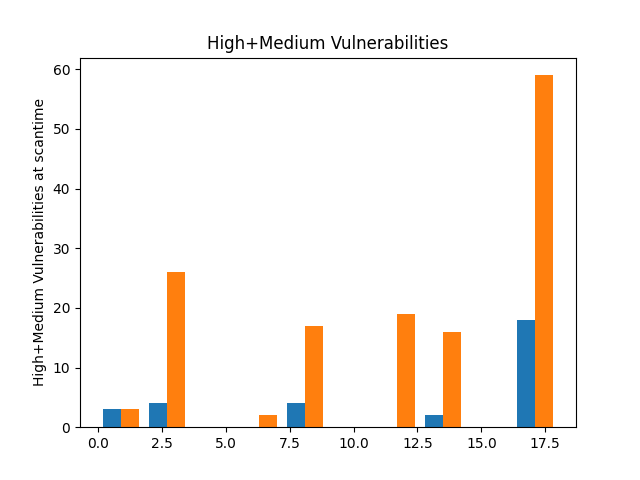

Text(0.5, 1.0, 'High+Medium Vulnerabilities')

In [37]:
%matplotlib notebook
plt.hist((benign_vulns, scam_vulns)) #label=annotations)
plt.ylabel("High+Medium Vulnerabilities at scantime")
plt.title("High+Medium Vulnerabilities")

In [132]:
slither_high_values = []
annotations = []
numbers = []

vuln_types_benign = {
    "abiencoderv2-array": 0,
    "array-by-reference": 0,
    "incorrect-shift": 0,
    "multiple-constructors": 0,
    "name-reused": 0,
    "public-mappings-nested": 0,
    "rtlo": 0,
    "shadowing-state": 0,
    "suicidal": 0,
    "uninitialized-state": 0,
    "uninitialized-storage": 0,
    "unprotected-upgrade": 0,
    "arbitrary-send": 0,
    "controlled-array-length": 0,
    "controlled-delegatecall": 0,
    "delegatecall-loop": 0,
    "msg-value-loop": 0,
    "reentrancy-eth": 0,
    "storage-array": 0,
    "unchecked-transfer": 0,
    "weak-prng": 0,
    "enum-conversion": 0,
    "erc20-interface": 0,
    "erc721-interface": 0,
    "incorrect-equality": 0,
    "locked-ether": 0,
    "mapping-deletion": 0,
    "shadowing-abstract": 0,
    "tautology": 0,
    "write-after-write": 0,
    "boolean-cst": 0,
    "constant-function-asm": 0,
    "constant-function-state": 0,
    "divide-before-multiply": 0,
    "reentrancy-no-eth": 0,
    "reused-constructor": 0,
    "tx-origin": 0,
    "unchecked-lowlevel": 0,
    "unchecked-send": 0,
    "uninitialized-local": 0,
    "unused-return": 0,
    "incorrect-modifier": 0,
    "shadowing-builtin": 0,
    "shadowing-local": 0,
    "uninitialized-fptr-cst": 0,
    "variable-scope": 0,
    "void-cst": 0,
    "calls-loop": 0,
    "events-access": 0,
    "events-maths": 0,
    "incorrect-unary": 0,
    "missing-zero-check": 0,
    "reentrancy-benign": 0,
    "reentrancy-events": 0,
    "timestamp": 0,
}

vuln_types_scam = {
    "abiencoderv2-array": 0,
    "array-by-reference": 0,
    "incorrect-shift": 0,
    "multiple-constructors": 0,
    "name-reused": 0,
    "public-mappings-nested": 0,
    "rtlo": 0,
    "shadowing-state": 0,
    "suicidal": 0,
    "uninitialized-state": 0,
    "uninitialized-storage": 0,
    "unprotected-upgrade": 0,
    "arbitrary-send": 0,
    "controlled-array-length": 0,
    "controlled-delegatecall": 0,
    "delegatecall-loop": 0,
    "msg-value-loop": 0,
    "reentrancy-eth": 0,
    "storage-array": 0,
    "unchecked-transfer": 0,
    "weak-prng": 0,
    "enum-conversion": 0,
    "erc20-interface": 0,
    "erc721-interface": 0,
    "incorrect-equality": 0,
    "locked-ether": 0,
    "mapping-deletion": 0,
    "shadowing-abstract": 0,
    "tautology": 0,
    "write-after-write": 0,
    "boolean-cst": 0,
    "constant-function-asm": 0,
    "constant-function-state": 0,
    "divide-before-multiply": 0,
    "reentrancy-no-eth": 0,
    "reused-constructor": 0,
    "tx-origin": 0,
    "unchecked-lowlevel": 0,
    "unchecked-send": 0,
    "uninitialized-local": 0,
    "unused-return": 0,
    "incorrect-modifier": 0,
    "shadowing-builtin": 0,
    "shadowing-local": 0,
    "uninitialized-fptr-cst": 0,
    "variable-scope": 0,
    "void-cst": 0,
    "calls-loop": 0,
    "events-access": 0,
    "events-maths": 0,
    "incorrect-unary": 0,
    "missing-zero-check": 0,
    "reentrancy-benign": 0,
    "reentrancy-events": 0,
    "timestamp": 0,
}


for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    slither_results = token['verified_contract']['slither_results']
    annotations.append(entry['Scam'])
#     if entry['Scam'] == 1:
#         numbers.append(index+200)
#     else:
#         numbers.append(index)
    numbers.append(index)

    
    if slither_results['error'] == 1:
        slither_high_values.append(-1)
        continue
    
    high_found = None
    unique_list = []
    for vuln in slither_results['vulnerabilities']:
        if vuln['check'] in unique_list:
            continue
            
        unique_list.append(vuln['check'])
        
        if entry['Scam'] == 1:
            vuln_types_scam[vuln['check']] += 1 
        else:
            vuln_types_benign[vuln['check']] += 1 


    if high_found is True:
        slither_high_values.append(1)
    else:
        slither_high_values.append(0)

# print(vuln_types_scam)
# print(vuln_types_benign)
print(len(slither_high_values))
print(len(annotations))

# %matplotlib notebook
# plt.scatter(numbers, slither_high_values , c=annotations) #label=annotations)
# plt.ylabel("Reentrancy Vulnerabilities at scantime")
# plt.title("Reentrancy Vulnerabilities")




344
344


<IPython.core.display.Javascript object>


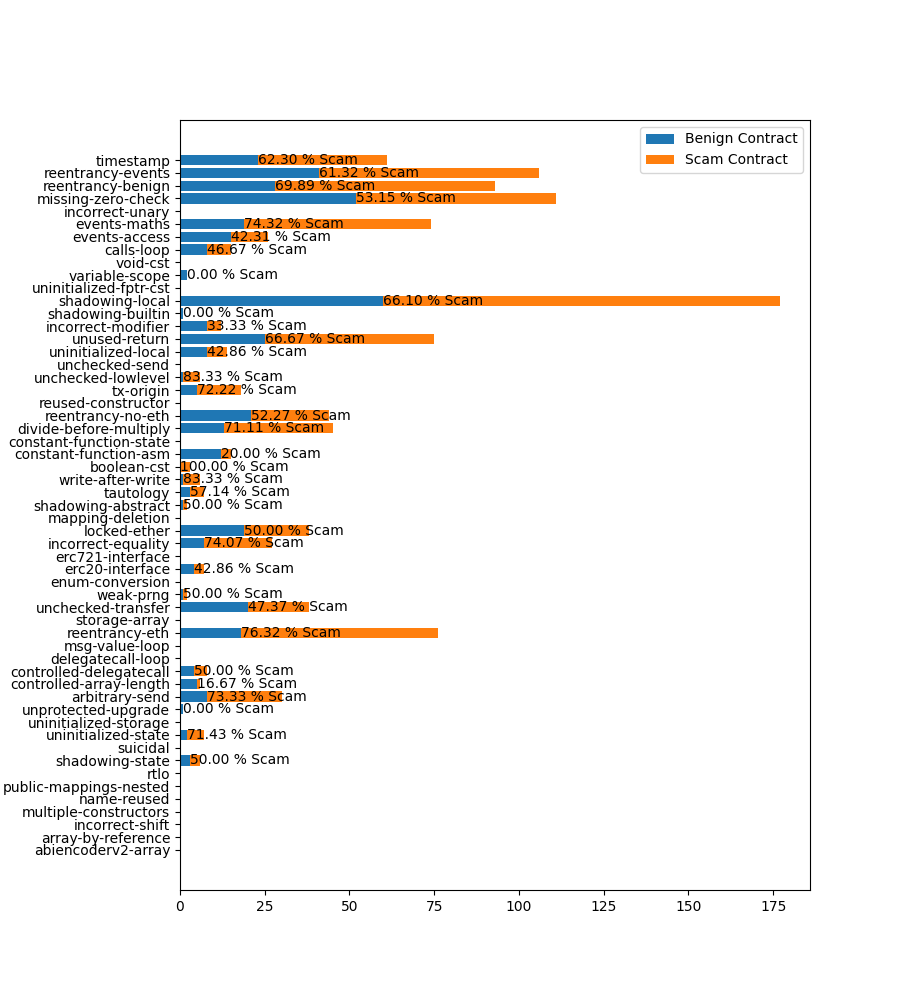

In [234]:
%matplotlib notebook

def addlabels(x,y,text):
    for i in range(len(x)):
        plt.text(y[i], x[i], text[i], va="center", ha='left')

# print(vuln_types_scam)
# print(vuln_types_benign)


vuln_types_scam_keys = list(vuln_types_scam.keys())
vuln_types_benign_keys = list(vuln_types_benign.keys())
vuln_types_scam_values = list(vuln_types_scam.values())
vuln_types_benign_values = list(vuln_types_benign.values())

importance = []

for i in range(len(vuln_types_benign_keys)):
    try:
        importance.append("{:.2f} % Scam".format(100/(vuln_types_benign_values[i] + vuln_types_scam_values[i])*vuln_types_scam_values[i]))
    except:
        importance.append("")

        
# print(importance)
fig, ax = plt.subplots(figsize =(9, 12))

plt.subplots_adjust(left=0.2)


plt.barh(vuln_types_benign_keys, vuln_types_benign_values,
        )
plt.barh(vuln_types_scam_keys, vuln_types_scam_values, left=vuln_types_benign_values)

addlabels(vuln_types_scam_keys, list(vuln_types_benign_values + vuln_types_scam_values), importance)
scam_labels = ['Benign Contract', 'Scam Contract']
plt.legend(scam_labels)

plt.show()

# (vuln_types_benign_values + vuln_types_scam_values)


In [40]:
importance = []
for i in range(len(vuln_types_benign_keys)):
    try:
        importance.append((vuln_types_benign_keys[i], 100/(vuln_types_benign_values[i] + vuln_types_scam_values[i])*vuln_types_scam_values[i]))
    except:
        importance.append((vuln_types_benign_keys[i], None))

df_importance = pd.DataFrame(importance)
df_importance

,0,1
0,abiencoderv2-array,NaN
1,array-by-reference,NaN
2,incorrect-shift,NaN
3,multiple-constructors,NaN
4,name-reused,NaN
5,public-mappings-nested,NaN
6,rtlo,NaN
7,shadowing-state,100.000000
8,suicidal,NaN
9,uninitialized-state,100.000000


In [187]:
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
import joblib
%matplotlib notebook

trainset_numbers = []
trainset_scores = []
trainset_annotations = []

train_scam_data = []
train_benign_data = []

test_scam_data = []
test_benign_data = []

for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    if token is None:
        print(entry['address'])
        continue
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)
    result, final_result = evaluator.get_score()
#     print(result)
#     print(final_result)
#     print(entry['Scam'])
    
    trainset_scores.append(final_result)
    trainset_annotations.append(entry['Scam'])
    trainset_numbers.append(index)
    if entry['Scam'] == 1:
        train_scam_data.append(final_result)
    else:
        train_benign_data.append(final_result)


testset_numbers = []
testset_scores = []
testset_annotations = []

for index, entry in data_testset.iterrows():
    token = testset_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    if token is None:
        print(entry['address'])
        continue
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)
    result, final_result = evaluator.get_score()
    testset_scores.append(final_result)
    testset_annotations.append(entry['Scam'])
    testset_numbers.append(index)
    if entry['Scam'] == 1:
        test_scam_data.append(final_result)
    else:
        test_benign_data.append(final_result)
    

    
# print(len(results))
# print(len(annotations))
# print(len(numbers))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_trainset_score_values = pd.DataFrame({"x": np.arange(len(trainset_scores)), "y":trainset_scores, "scam":trainset_annotations})
df_testset_score_values = pd.DataFrame({"x": np.arange(len(testset_scores)), "y":testset_scores, "scam":testset_annotations})

plot_colors = []

for i in trainset_annotations:
    plot_colors.append(colors[i])

plot_colors_test = []

for i in testset_annotations:
    plot_colors_test.append(colors[i])

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()

X_train = np.array(trainset_scores).reshape(-1, 1)

X_train = scaler.fit_transform(X_train)


X_test = np.array(testset_scores).reshape(-1, 1)

X_test = scaler.transform(X_test)
# print(X)
# X_train,X_test,y_train,y_test = train_test_split(X,annotations,test_size=0.3,random_state=0)  



In [188]:
import joblib
classifier = SVC(kernel='linear', probability=True)
# classifier = joblib.load('evaluation/svc_linear_classifier_bak.joblib')
# scaler = joblib.load('evaluation/data_scaler_bak.joblib')

classifier.fit(X_train, trainset_annotations)

#train
y_pred_train = classifier.predict(X_train)

tn, fp, fn, tp = metrics.confusion_matrix(trainset_annotations, y_pred_train).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(trainset_annotations, y_pred_train))
print("F1 Score:",metrics.f1_score(trainset_annotations, y_pred_train))

y_pred_proba = classifier.predict_proba(X_train)[::,1]
# for i in range(len(y_pred_train)):
#     if y_pred_train[i] != trainset_annotations[i]:
#         print((y_pred_train[i], y_pred_proba[i], trainset_annotations[i]))

#test
y_pred = classifier.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(testset_annotations, y_pred).ravel()
print((tn, fp, fn, tp))

#
print("Accuracy:",metrics.accuracy_score(testset_annotations, y_pred))
print("F1 Score:",metrics.f1_score(testset_annotations, y_pred))



y_pred_proba = classifier.predict_proba(X_test)[::,1]
# for i in range(len(y_pred)):
#     if y_pred[i] != testset_annotations[i]:
#         print((y_pred[i], y_pred_proba[i], testset_annotations[i]))


# joblib.dump(scaler, 'evaluation/custom_data_scaler.joblib')
# joblib.dump(classifier, 'evaluation/svc_linear_classifier.joblib')
# classifier = joblib.load('evaluation/svc_linear_classifier.joblib')


(110, 44, 34, 156)
Accuracy: 0.7732558139534884
F1 Score: 0.8
(6, 10, 17, 61)
Accuracy: 0.7127659574468085
F1 Score: 0.8187919463087248


(1, 30, 0, 142)
Accuracy: 0.8265895953757225
F1 Score: 0.9044585987261146
(0, 16, 0, 78)
Accuracy: 0.8297872340425532
F1 Score: 0.9069767441860465
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.95651561 0.80844543 0.9269379  0.70881222 0.90597217 0.80844543
 0.70881222 0.80844543 0.8797705  0.8797705  0.51603075 0.64895824
 0.78530567 0.8797705  0.8797705  0.78530567 0.80844543 0.9269379
 0.64895824 0.76220043 0.76220043 0.97444944 0.70881222 0.80844543
 0.8797705  0.70881222 0.80844543 0.8797705  0.86144746 0.8797705
 0.70881222 0.70881222 0.8797705  0.9269379  0.9269379  0.92389971
 0.80844543 0.80153486 0.80844543 0.70881222 0.8797705  0.80844543
 0.80844543 0.70881222 0.80844543 0.70881222 0.70881222 0.80844543
 0.80844543 0.98444209 0.80844543 0.70881222 0.80844543 0.8797705
 0.64895824 0.95651561 0.8797705  0.80844543 0.64895824 0.708

<IPython.core.display.Javascript object>


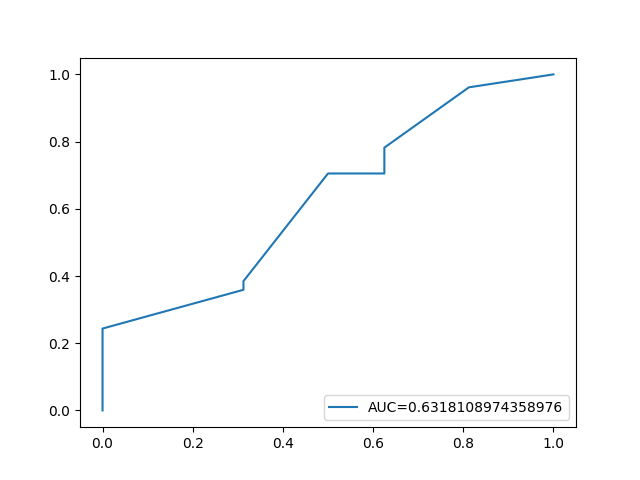

In [43]:
from sklearn.linear_model import LogisticRegression

log_regression = LogisticRegression()

log_regression.fit(X_train,trainset_annotations)


y_pred_train = log_regression.predict(X_train)

tn, fp, fn, tp = metrics.confusion_matrix(trainset_annotations, y_pred_train).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(trainset_annotations, y_pred_train))
print("F1 Score:",metrics.f1_score(trainset_annotations, y_pred_train))


y_pred = log_regression.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(testset_annotations, y_pred).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(testset_annotations, y_pred))
print("F1 Score:",metrics.f1_score(testset_annotations, y_pred))

# joblib.dump(log_regression, 'evaluation/log_regression_classifier.joblib')

%matplotlib notebook

print(y_pred)
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
print(y_pred_proba)
fpr, tpr, _ = metrics.roc_curve(testset_annotations,  y_pred_proba)
auc = metrics.roc_auc_score(testset_annotations, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

# x_scam = np.sort(pdf_scam_data)
# y_scam = 1. * np.arange(len(pdf_scam_data)) / (len(pdf_scam_data) - 1)

# x_benign = np.sort(pdf_benign_data)
# y_benign = 1. * np.arange(len(pdf_benign_data)) / (len(pdf_benign_data) - 1)
# plt.plot(x_scam, y_scam)

# plt.plot(x_benign, y_benign)



<IPython.core.display.Javascript object>


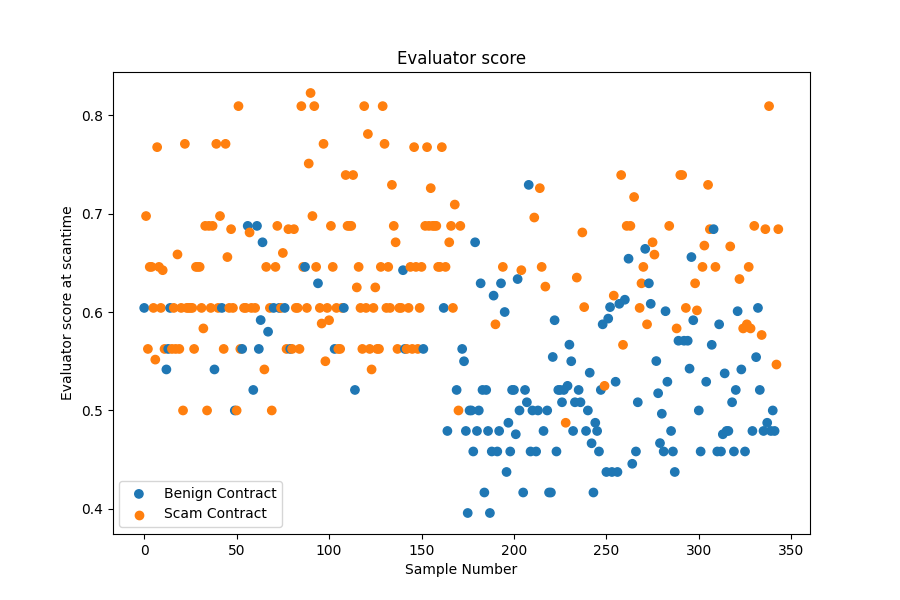

In [189]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

ax.scatter(trainset_numbers, df_trainset_score_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(None, None, c=colors[1], label="Scam Contract")
ax.legend()
# plt.scatter(trainset_numbers, trainset_scores , c=trainset_annotations)
plt.ylabel("Evaluator score at scantime")
plt.xlabel("Sample Number")
plt.title("Evaluator score")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


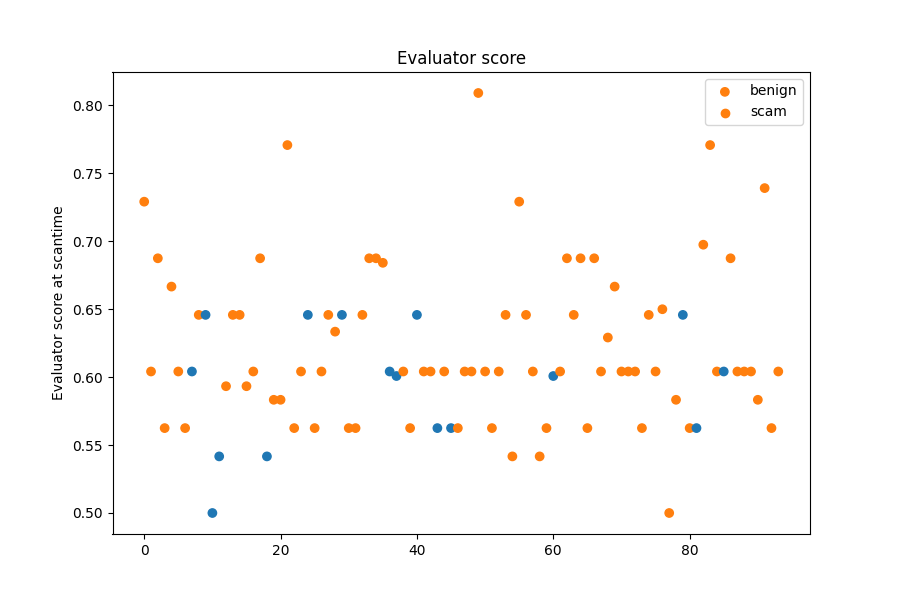

In [179]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))
ax.scatter(testset_numbers, df_testset_score_values['y'] , c=plot_colors_test, label="benign") #label=annotations)
ax.scatter(None, None, c=colors[1], label="scam")
ax.legend()
# plt.scatter(testset_numbers, testset_scores , c=testset_annotations)
plt.ylabel("Evaluator score at scantime")
plt.title("Evaluator score")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


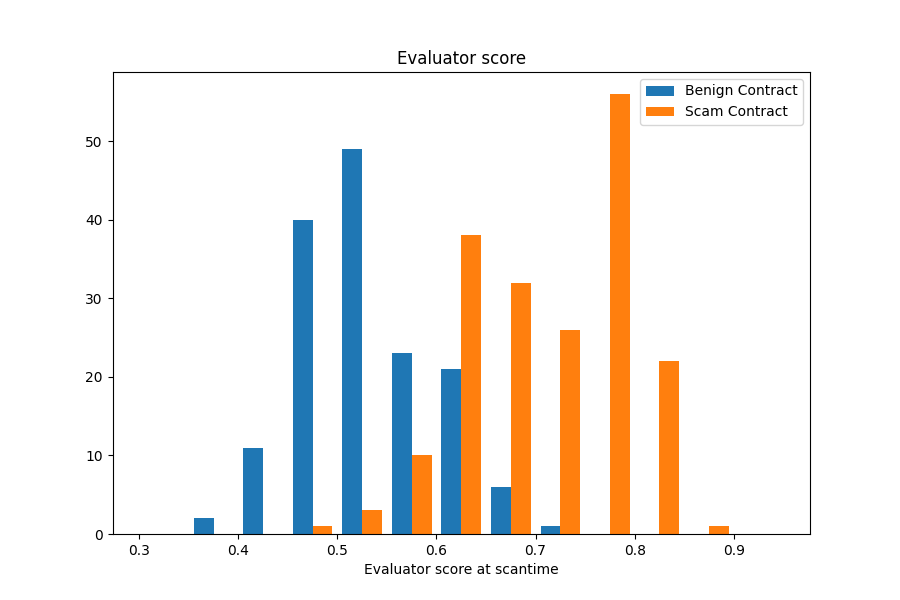

In [183]:

%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))


ax.hist((train_benign_data, train_scam_data), bins=np.arange(0.3,1,0.05))
plt.xlabel("Evaluator score at scantime")
plt.title("Evaluator score")
plt.legend(["Benign Contract", "Scam Contract"])
plt.show()


<IPython.core.display.Javascript object>


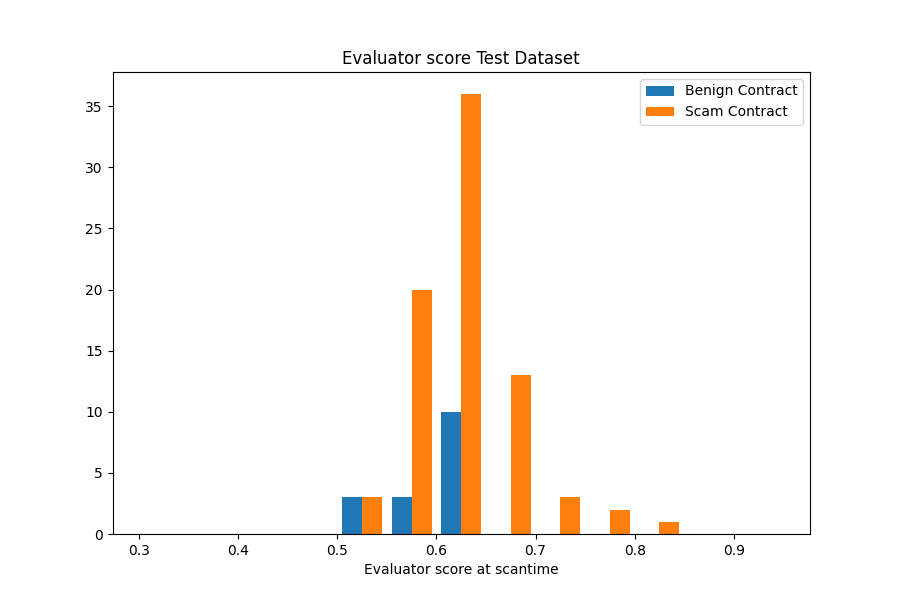

In [170]:

%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))


ax.hist((test_benign_data, test_scam_data), bins=np.arange(0.3,1,0.05))
plt.xlabel("Evaluator score at scantime")
plt.title("Evaluator score Test Dataset")
plt.legend(["Benign Contract", "Scam Contract"])
plt.show()

In [160]:


su.evaluate_dataset(statistics_db, data)
su.evaluate_dataset(statistics_rescan_db, data)


{
    "liquidity_share_result": {
        "tp": 176,
        "fn": 11,
        "fp": 61,
        "tn": 89,
        "undecided": 7,
        "unknown": 0
    },
    "holder_share_result": {
        "tp": 53,
        "fn": 0,
        "fp": 22,
        "tn": 0,
        "undecided": 269,
        "unknown": 0
    },
    "liquidity_amount_result": {
        "tp": 77,
        "fn": 9,
        "fp": 34,
        "tn": 42,
        "undecided": 182,
        "unknown": 0
    },
    "honeypot_result": {
        "tp": 57,
        "fn": 0,
        "fp": 8,
        "tn": 0,
        "undecided": 279,
        "unknown": 0
    },
    "ownership_result": {
        "tp": 79,
        "fn": 0,
        "fp": 28,
        "tn": 0,
        "undecided": 237,
        "unknown": 0
    },
    "verified_contract_result": {
        "tp": 27,
        "fn": 0,
        "fp": 6,
        "tn": 0,
        "undecided": 311,
        "unknown": 0
    },
    "vulnerabilities_result": {
        "tp": 139,
        "fn": 18,
      

TypeError: 'NoneType' object is not subscriptable